<h1> DATAFRAME IMPLENENTATION</h1>

<h2> Import datasets</h2>

In [0]:
fileroot = "clinicaltrial_2021.csv"
import os
os.environ['fileroot'] = fileroot
dbutils.fs.cp("/FileStore/tables/"+ fileroot + ".gz", "file:/tmp/", True)

Out[1]: True

In [0]:
%sh
gunzip -d /tmp/ /tmp/$fileroot.gz

gzip: /tmp/ is a directory -- ignored
gzip: /tmp/clinicaltrial_2021.csv already exists;	not overwritten


In [0]:
dbutils.fs.cp ("file:/tmp/" + fileroot , "/FileStore/" + fileroot, True)

Out[3]: True

In [0]:
data = "/FileStore/"+ fileroot
# Create an DF
clinical_df = spark.read.options(header=True, delimiter='|').csv(data)
clinical_df.show(5)

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+-------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+-------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|         null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|         null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|         null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  May 2016|Tuberculosis,Lung...|         null|

In [0]:
fileroot_ = "mesh"
data = "/FileStore/"+ fileroot_ + ".csv"
# Create an RDD
mesh_df = spark.read.options(header=True, delimiter=',').csv(data)
mesh_df.show(5, False)

+----------+-------------------+
|term      |tree               |
+----------+-------------------+
|Calcimycin|D03.633.100.221.173|
|A-23187   |D03.633.100.221.173|
|Temefos   |D02.705.400.625.800|
|Temefos   |D02.705.539.345.800|
|Temefos   |D02.886.300.692.800|
+----------+-------------------+
only showing top 5 rows



In [0]:
fileroot_ = "pharma"
data = "/FileStore/tables/"+ fileroot_ + ".csv"
# Create an RDD
pharma_df = spark.read.options(header=True, delimiter=',').csv(data)
pharma_df.show(5, False)

+-------------------------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+---------------------------------------+-----------------------------------------------------+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------+-------------------

<h2> Question 1</h2>
<h3> The number of studies in the dataset. </h3>

In [0]:
clinical_df.distinct().count()

Out[7]: 387261

<h2> Question 2</h2>
<h3> The types of studies in the dataset and count of each type. </h3>

In [0]:
type_df = clinical_df.groupBy('Type').count().sort('count',ascending=False)
type_df.show(5, False)

+--------------------------------+------+
|Type                            |count |
+--------------------------------+------+
|Interventional                  |301472|
|Observational                   |77540 |
|Observational [Patient Registry]|8180  |
|Expanded Access                 |69    |
+--------------------------------+------+



<h2> Question 3</h2>
<h3> The top 5 conditions with their frequency. </h3>

In [0]:
from pyspark.sql import functions as F

In [0]:
split_df = clinical_df.withColumn('cond_df', F.split(clinical_df['Conditions'], ",")).filter(clinical_df['Conditions']!= 'null')
sd = split_df.withColumn('Disease', F.explode(split_df.cond_df))
sd.show(5)

+-----------+--------------------+---------+--------+----------+--------------+----------+--------------------+-------------+--------------------+--------------------+
|         Id|             Sponsor|   Status|   Start|Completion|          Type|Submission|          Conditions|Interventions|             cond_df|             Disease|
+-----------+--------------------+---------+--------+----------+--------------+----------+--------------------+-------------+--------------------+--------------------+
|NCT02751957|     Duke University|Completed|Jul 2016|  Jul 2020|Interventional|  Apr 2016|Autistic Disorder...|         null|[Autistic Disorde...|   Autistic Disorder|
|NCT02751957|     Duke University|Completed|Jul 2016|  Jul 2020|Interventional|  Apr 2016|Autistic Disorder...|         null|[Autistic Disorde...|Autism Spectrum D...|
|NCT02758483|Universidade Fede...|Completed|Mar 2017|  Jan 2018|Interventional|  Apr 2016|   Diabetes Mellitus|         null| [Diabetes Mellitus]|   Diabetes Me

In [0]:
cond_df = sd.groupby('Disease').agg(F.count('Disease').alias('Condition_freq')).orderBy('Condition_freq', ascending = False)
cond_df.show(5)

+-----------------+--------------+
|          Disease|Condition_freq|
+-----------------+--------------+
|        Carcinoma|         13389|
|Diabetes Mellitus|         11080|
|        Neoplasms|          9371|
| Breast Neoplasms|          8640|
|         Syndrome|          8032|
+-----------------+--------------+
only showing top 5 rows



<h2> Question 4</h2>
<h3> The most frequent roots. </h3>

In [0]:
split_mesh = mesh_df.join(sd, mesh_df['term'] == sd['Disease'],"inner")
split_mesh.withColumn('root', split_mesh['tree'].substr(1, 3))\
.select('term', 'root').groupby('root').agg(F.count('root')\
.alias('root_freq')).orderBy('root_freq', ascending = False).show(5)

+----+---------+
|root|root_freq|
+----+---------+
| C04|   143994|
| C23|   136079|
| C01|   106674|
| C14|    94523|
| C10|    92310|
+----+---------+
only showing top 5 rows



<h2> Question 5</h2>
<h3> The 10 most common sponsors that are not pharmaceutical companies. </h3>

In [0]:
sponsors_not_pharmas = clinical_df.join(pharma_df, clinical_df['Sponsor'] == pharma_df['Parent_Company'], "left")\
                       .filter(F.col('Parent_Company').isNull())

In [0]:
sponsors_not_pharmas.groupBy('Sponsor').agg(F.count('Sponsor').alias('Sponsor_freq'))\
.orderBy('Sponsor_freq', ascending=False).show(10, False)

+---------------------------------------+------------+
|Sponsor                                |Sponsor_freq|
+---------------------------------------+------------+
|National Cancer Institute (NCI)        |3218        |
|M.D. Anderson Cancer Center            |2414        |
|Assistance Publique - Hôpitaux de Paris|2369        |
|Mayo Clinic                            |2300        |
|Merck Sharp & Dohme Corp.              |2243        |
|Assiut University                      |2154        |
|Novartis Pharmaceuticals               |2088        |
|Massachusetts General Hospital         |1971        |
|Cairo University                       |1928        |
|Hoffmann-La Roche                      |1828        |
+---------------------------------------+------------+
only showing top 10 rows



<h2> Question 6</h2>
<h3> The number of completed studies each month in a given year. </h3>

In [0]:
year = fileroot[14:18]
tr = clinical_df.filter((clinical_df['Completion']).contains (year))\
     .filter( (clinical_df['status'] == 'Completed')).select('Completion')\
     .groupBy('Completion').count()

studies_df = tr.withColumn('month', tr['Completion'].substr(1, 3)).select('month', 'count')
studies_df.show()

+-----+-----+
|month|count|
+-----+-----+
|  Mar| 1227|
|  Sep|  528|
|  May|  984|
|  Oct|  187|
|  Jun| 1094|
|  Feb|  934|
|  Aug|  700|
|  Jan| 1131|
|  Jul|  819|
|  Apr|  967|
+-----+-----+



In [0]:
for row in studies_df:
    st_df = dict(studies_df.collect())
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
e_list = []
for m in months:
    st = (m, st_df[m])
    e_list.append(st)
print(e_list)

[('Jan', 1131), ('Feb', 934), ('Mar', 1227), ('Apr', 967), ('May', 984), ('Jun', 1094), ('Jul', 819), ('Aug', 700), ('Sep', 528), ('Oct', 187)]


In [0]:
list_df = spark.sparkContext.parallelize(e_list)
month_df = spark.createDataFrame(list_df)

In [0]:
studies_df = month_df.withColumnRenamed("_1","Month")\
             .withColumnRenamed("_2","count")
studies_df.show()

+-----+-----+
|Month|count|
+-----+-----+
|  Jan| 1131|
|  Feb|  934|
|  Mar| 1227|
|  Apr|  967|
|  May|  984|
|  Jun| 1094|
|  Jul|  819|
|  Aug|  700|
|  Sep|  528|
|  Oct|  187|
+-----+-----+



Out[19]: <AxesSubplot:xlabel='Month', ylabel='count'>

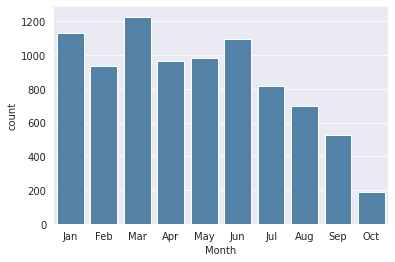

In [0]:
import seaborn as sns
sns.set_style('darkgrid')
sns.barplot(data=studies_df.toPandas(), x="Month", y="count",color='steelblue', order = months )

<h2> Further analysis</h2>
<h3> The number of offenses in a given year. </h3>

In [0]:
offense_df = pharma_df.filter((pharma_df['Penalty_Year']).contains(year))\
         .groupBy('Offense_Group').count().orderBy('count', ascending=False)

offense_df.show(5, False)

+---------------------------------------+-----+
|Offense_Group                          |count|
+---------------------------------------+-----+
|healthcare-related offenses            |4    |
|government-contracting-related offenses|4    |
|environment-related offenses           |2    |
|safety-related offenses                |2    |
|employment-related offenses            |1    |
+---------------------------------------+-----+

